In [1]:
!cp -r /kaggle/input/xlstmm/xlstm-main/xlstm /kaggle/working/xlstm

In [2]:
import sys
sys.path.append('/kaggle/working/xlstm')

In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, Normalizer, LabelEncoder
from tensorflow.keras.models import Model
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xlstm import (
    xLSTMBlockStack,
    xLSTMBlockStackConfig,
    mLSTMBlockConfig,
    mLSTMLayerConfig,
    sLSTMBlockConfig,
    sLSTMLayerConfig,
    FeedForwardConfig,
)
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split

2025-07-02 08:08:23.865596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751443704.134740      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751443704.204811      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Đặt lại số lượng cột hiển thị tối đa
pd.set_option('display.max_columns', None)  # Hiển thị tất cả các cột

# Đặt lại số lượng dòng hiển thị tối đa
pd.set_option('display.max_rows', None) 

In [5]:
df = pd.read_csv('/kaggle/input/flowfeatures/flowFeatures.csv', header=0)

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


In [6]:
df.head()

,publicIP,FlowID,SrcIP,SrcPort,DstIP,DstPort,Protocol,Timestamp,FlowDuration,TotFwdPkts,TotBwdPkts,TotLenFwdPkts,TotLenBwdPkts,FwdPktLenMax,FwdPktLenMin,FwdPktLenMean,FwdPktLenStd,BwdPktLenMax,BwdPktLenMin,BwdPktLenMean,BwdPktLenStd,FlowByts/s,FlowPkts/s,FlowIATMean,FlowIATStd,FlowIATMax,FlowIATMin,FwdIATTot,FwdIATMean,FwdIATStd,FwdIATMax,FwdIATMin,BwdIATTot,BwdIATMean,BwdIATStd,BwdIATMax,BwdIATMin,FwdPSHFlags,BwdPSHFlags,FwdURGFlags,BwdURGFlags,FwdHeaderLen,BwdHeaderLen,FwdPkts/s,BwdPkts/s,PktLenMin,PktLenMax,PktLenMean,PktLenStd,PktLenVar,FINFlagCnt,SYNFlagCnt,RSTFlagCnt,PSHFlagCnt,ACKFlagCnt,URGFlagCnt,CWEFlagCount,ECEFlagCnt,Down/UpRatio,PktSizeAvg,FwdSegSizeAvg,BwdSegSizeAvg,FwdByts/bAvg,FwdPkts/bAvg,FwdBlkRateAvg,BwdByts/bAvg,BwdPkts/bAvg,BwdBlkRateAvg,SubflowFwdPkts,SubflowFwdByts,SubflowBwdPkts,SubflowBwdByts,InitFwdWinByts,InitBwdWinByts,FwdActDataPkts,FwdSegSizeMin,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,104.20.150.33,192.168.1.55-104.20.150.33-49602-443-6,192.168.1.55,49602,104.20.150.33,443,6,01/03/2020 10:31:05 PM,94589801,22,22,1206.0,15553.0,517.0,0.0,54.818182,149.077045,1412.0,0.0,706.954545,680.975664,1.771755e+02,0.465166,2.199763e+06,9.779565e+06,45953360.0,1.0,94276757.0,4.489369e+06,1.380058e+07,46026880.0,7.0,94589801.0,4.504276e+06,1.382077e+07,46093055.0,1.0,0,0,0,0,440,476,0.232583,0.232583,0.0,1412.0,372.422222,584.359381,341475.885859,0,1,0,0,0,0,0,0,1.0,380.886364,54.818182,706.954545,0,0,0,0,0,0,22,1206,22,15553,-1,67,5,0,1271693.0,1.683627e+06,2462197.0,81189.0,45949525.5,5422.801905,45953360.0,45945691.0,BENIGN
1,104.20.150.33,192.168.1.55-104.20.150.33-49602-443-6,192.168.1.55,49602,104.20.150.33,443,6,01/03/2020 10:33:26 PM,92394311,2,4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.064939,1.847886e+07,2.518021e+07,46158858.0,87570.0,46056963.0,4.605696e+07,0.000000e+00,46056963.0,46056963.0,92394311.0,3.079810e+07,2.659338e+07,46250073.0,90920.0,0,0,0,0,40,80,0.021646,0.043293,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,2.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,2,0,4,0,-1,67,0,0,91067.5,2.085965e+02,91215.0,90920.0,46062303.0,136549.390515,46158858.0,45965748.0,BENIGN
2,104.20.150.33,192.168.1.55-104.20.150.33-49602-443-6,192.168.1.55,49602,104.20.150.33,443,6,01/03/2020 10:35:44 PM,91660550,2,4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.065459,1.833211e+07,2.498128e+07,45807627.0,82390.0,45669960.0,4.566996e+07,0.000000e+00,45669960.0,45669960.0,91660550.0,3.055352e+07,2.638249e+07,45890017.0,89884.0,0,0,0,0,40,80,0.021820,0.043639,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,2.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,2,0,4,0,-1,67,0,0,86137.0,5.299058e+03,89884.0,82390.0,45697598.5,155603.796948,45807627.0,45587570.0,BENIGN
3,104.20.150.33,192.168.1.55-104.20.150.33-49602-443-6,192.168.1.55,49602,104.20.150.33,443,6,01/03/2020 10:37:48 PM,3,0,3,0.0,63.0,0.0,0.0,0.000000,0.000000,39.0,0.0,21.000000,19.672316,2.100000e+07,1000000.000000,1.500000e+00,7.071068e-01,2.0,1.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,3.0,1.500000e+00,7.071068e-01,2.0,1.0,0,1,0,0,0,60,0.000000,1000000.000000,0.0,39.0,21.750000,16.132266,260.250000,0,0,0,1,1,0,0,0,0.0,29.000000,0.000000,21.000000,0,0,0,0,0,0,0,0,3,63,-1,67,0,0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,BENIGN
4,104.20.150.33,192.168.1.55-104.20.150.33-49602-443-6,192.168.1.55,49602,104.20.150.33,443,6,01/03/2020 10:37:48 PM,484,3,1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,8264.462810,1.613333e+02,2.569287e+02,458.0,11.0,469.0,2.345000e+02,3.160767e+02,458.0,11.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,0,0,60,32,6198.347107,2066.115702,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,3,0,1,0,-1,4096,0,0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,BENIGN


In [7]:
columns = df.iloc[:,8:84].columns.insert(0, 'Protocol')

In [8]:
df = df.replace([np.inf, -np.inf], np.nan)
df.dropna(inplace = True, subset=columns)
df.drop_duplicates(inplace = True)
df.reset_index(drop=True, inplace=True)

In [9]:
for i in df.columns:
    if len(df[i].unique()) == 1:
        df.drop(columns=i, axis=1, inplace=True)

In [10]:
columns = df.iloc[:,8:72].columns.insert(0, 'Protocol')

In [11]:
def convert_to_float(df, name):
    df[name] = df[name].astype(np.float64)

In [12]:
i = 0
while i != len(columns):
  convert_to_float(df, columns[i])
  i = i + 1

In [13]:
# df['IP1'] = df[['SrcIP', 'DstIP']].min(axis=1)
# df['IP2'] = df[['SrcIP', 'DstIP']].max(axis=1)
# unique_group = df.groupby(['IP1', 'IP2'])

In [14]:
# for pair, i in unique_group:
#     if len(i['Label'].unique()) > 1:
#         print(pair)

In [15]:
def create_ip_pair(src_ip, dst_ip):
    return tuple(sorted([src_ip, dst_ip]))

In [16]:
X = df[columns]
y = df['Label']
ip_pairs = [create_ip_pair(src, dst) for src, dst in zip(df['SrcIP'], df['DstIP'])]

In [17]:
X_train, X_test, y_train, y_test, ip_pairs_train, ip_pairs_test = train_test_split(
    X, y, ip_pairs, test_size=0.2, random_state=42, stratify=y
)

In [18]:
X_test.shape

(334232, 65)

In [19]:
stan = StandardScaler()
X_train = stan.fit_transform(X_train)
X_test = stan.transform(X_test)

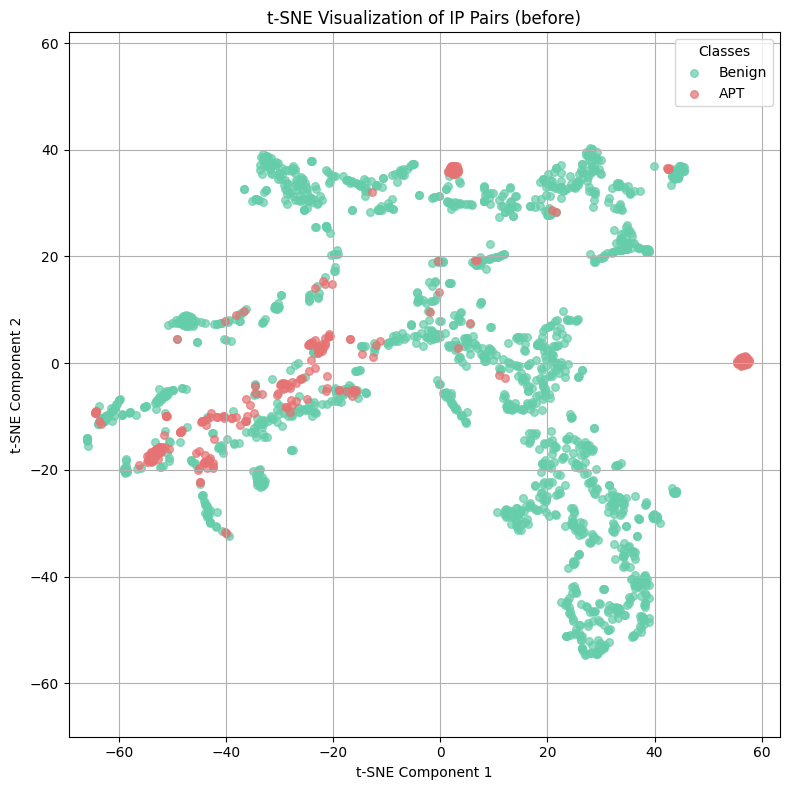

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Lấy 65 đặc trưng
columns = df.iloc[:, 8:72].columns.insert(0, 'Protocol')
X = df[columns].values
y = df['Label'].values

# Tạo IP pair
def create_ip_pair(src, dst):
    return tuple(sorted([src, dst]))

ip_pairs = [create_ip_pair(s, d) for s, d in zip(df['SrcIP'], df['DstIP'])]

# Gom theo IP pair
ip_dict = defaultdict(list)
label_dict = {}

for i, ip in enumerate(ip_pairs):
    ip_dict[ip].append(X[i])
    label_dict[ip] = y[i]

# Vector đại diện mỗi IP pair = trung bình các flow của nó
ip_vectors = []
ip_labels = []

for ip, flows in ip_dict.items():
    mat = np.array(flows)  # [n_flow, 65]
    vec = mat.mean(axis=0)  # [65,]
    ip_vectors.append(vec)
    ip_labels.append(1 if label_dict[ip] == 'APT' else 0)

# Tính t-SNE
X_tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)\
            .fit_transform(np.array(ip_vectors))

# Vẽ từng lớp riêng biệt
X = X_tsne
y = np.array(ip_labels)

plt.figure(figsize=(8, 8))
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='#66CDAA', label='Benign', alpha=0.7, s=30)
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='#E57373', label='APT', alpha=0.7, s=30)

plt.title('t-SNE Visualization of IP Pairs (before)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Classes')
plt.grid(True)
plt.axis('equal')
plt.xlim(-70, 64)
plt.ylim(-70, 62)
plt.tight_layout()
plt.show()

In [21]:
class IPFrameDataset(Dataset):
    def __init__(self, X, y, ip):
        self.leng = []
        self.frames = []
        self.labels = []
        self.IDK_yet = None

        X_num = X if isinstance(X, np.ndarray) else X.values
        y_num = y.values if hasattr(y, 'values') else np.array(y)
        
        unique_ip_pairs = set(ip)
        for pair in unique_ip_pairs:
            indexes = []
            select_flows = None
            leng = None
            frame_labels = None
            for index, i in enumerate(ip):
                if i == pair:
                    indexes.append(index)
            if len(indexes) > 0:
                indexes = sorted(indexes)
                samples = X_num[indexes]
                frame_labels = y_num[indexes]
                # print(np.unique(frame_labels))
                # print('---------------')
                if len(samples) < 514:
                    select_flows = samples
                    padding = np.zeros((514 - len(samples), samples.shape[1]))
                    select_flows = np.vstack([select_flows, padding])
                    leng = len(samples)
                else:
                    random = np.random.choice(samples.shape[0], size=514, replace=False)
                    random = sorted(random)
                    select_flows = samples[random]
                    leng = 514
            self.frames.append(select_flows)
            self.labels.append(1 if frame_labels[0] == 'APT' else 0)
            self.leng.append(leng)

        # self.leng, idx = sorted(self.leng)
        # self.frames = self.frames[idx]
        # self.labels = self.labels[idx]
        
        self.frames = torch.FloatTensor(np.array(self.frames))
        self.labels = torch.FloatTensor(self.labels)
        self.leng = torch.LongTensor(self.leng)

        self.leng, idx = torch.sort(self.leng)
        self.frames = self.frames[idx]
        self.labels = self.labels[idx]

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        return (
            self.frames[idx],
            self.labels[idx],
            self.leng[idx]
    )                           

In [22]:
trainset = IPFrameDataset(X_train, y_train, ip_pairs_train)
testset = IPFrameDataset(X_test, y_test, ip_pairs_test)

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

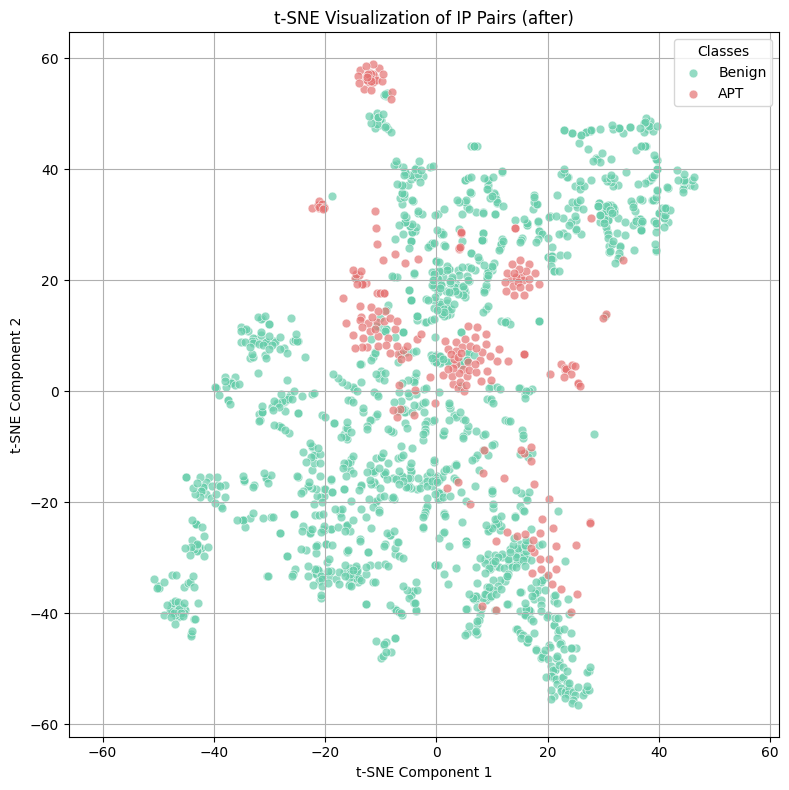

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Lấy dữ liệu từ trainset
X_embed = trainset.frames.numpy().reshape(len(trainset), -1)  # [N, 514 * 65]
y_embed = trainset.labels.numpy()

# Áp dụng t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_embed)

# Màu sắc tương ứng
colors = {0: '#66CDAA', 1: '#E57373'}  # 0: Benign, 1: APT

# Vẽ scatter từng lớp
plt.figure(figsize=(8, 8))
for label in np.unique(y_embed):
    plt.scatter(X_tsne[y_embed == label, 0], 
                X_tsne[y_embed == label, 1], 
                c=colors[label], 
                label='Benign' if label == 0 else 'APT', 
                alpha=0.7, 
                s=40,
                edgecolor='white',
                linewidth=0.5)

plt.title('t-SNE Visualization of IP Pairs (after)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Classes')
plt.xlim(-70, 64)
plt.ylim(-70, 62)
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


In [24]:
train_loader = DataLoader(
    trainset,
    batch_size=1,
    shuffle=False,
    pin_memory=True
)

test_loader = DataLoader(
    testset,
    batch_size=1,
    shuffle=False,
    pin_memory=True
)

In [25]:
class xTransformer(nn.Module):
    def __init__(self):
        # xLSTM + Transformers
        super(xTransformer, self).__init__()
        
        self.embedding = nn.Sequential(nn.Linear(65, 128),
                                      nn.LayerNorm(128),
                                      nn.SiLU(),
                                      nn.Dropout(0.2))
        
        cfg = xLSTMBlockStackConfig(
            mlstm_block=mLSTMBlockConfig(
                mlstm=mLSTMLayerConfig(
                    conv1d_kernel_size=32, qkv_proj_blocksize=4, num_heads=4
                )
            ),
            slstm_block=sLSTMBlockConfig(
                slstm=sLSTMLayerConfig(
                    backend="vanilla",
                    num_heads=4,
                    conv1d_kernel_size=32,
                    bias_init="powerlaw_blockdependent",
                ),
                feedforward=FeedForwardConfig(proj_factor=1.5, act_fn="relu"),
            ),
            context_length=514,
            num_blocks=6,
            embedding_dim=128,
            slstm_at=[1],
        )
        # 4,4,5 (mô hình gốc)
        self.xLSTM = xLSTMBlockStack(cfg)
        # self.biLSTM = nn.LSTM(
        #     input_size = 128,
        #     hidden_size = 128,
        #     num_layers=2,
        #     bidirectional=True,
        #     batch_first=True,
        #     dropout=0.2
        # )
        
        
        Tlay = TransformerEncoderLayer(d_model=128, nhead=16, dropout=0.2, batch_first=True)
        self.Transformer_Encoder = TransformerEncoder(Tlay, num_layers=5)
        # self.CNNPooling = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        # self.pool = nn.AdaptiveAvgPool1d(1)
        self.compress = nn.Sequential(nn.Linear(128, 64),
                                      nn.LayerNorm(64),
                                      nn.SiLU(),
                                      nn.Dropout(0.2),
                                     )
        self.out = nn.Linear(64, 1)
    def forward(self, x, leng):
        #Input: [1,<=512, 65]
        x = self.embedding(x)
        #Output: [1,<=512, 128]
        x = self.xLSTM(x)
        # x,_ = self.biLSTM(x)
        #Output: [1,<=512, 128]
        # x = self.Transformer_Encoder(x)
        # x = torch.mean(x, dim=1)
        #Output: [1,<=512, 128]
        x = torch.mean(x, dim=1)
        #Tiếp tực đưa vào CNN
        # x = x.permute(0, 2, 1)
        # x = self.CNNPooling(x)
        # x = self.pool(x)
        # x = x.view(x.size(0), -1)
        x = self.compress(x)
        x = self.out(x)
        # x = self.classification(x)
        return x

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
model = xTransformer().to(device)

In [28]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [29]:
def valid(data, model):
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for frames, labels, leng in data:
            labels = labels.to(device)
            if leng != 514:
                idx_range = torch.arange(leng[0])
                frames = frames[0][idx_range].unsqueeze(0).to(device)
                leng = leng.to(device)
            else:
                frames = frames.to(device)
                leng = leng.to(device)
            outputs = model(frames, leng)
            outputs = outputs.view(-1)
    
            preds = torch.sigmoid(outputs.detach())
            preds = (preds > 0.5).float()
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    # print(val_preds)
    # print(val_labels)
    val_acc = accuracy_score(val_labels, val_preds)
    return val_preds, val_labels, val_acc

In [30]:
for epoch in range(15):
    model.train()
    train_preds = []
    train_labels = []
    total_loss = 0
    for frames, labels, leng in train_loader:
        labels = labels.to(device)
        if leng != 514:
            idx_range = torch.arange(leng[0])
            frames = frames[0][idx_range].unsqueeze(0).to(device)
            leng = leng.to(device)
        else:
            frames = frames.to(device)
            leng = leng.to(device)
        optimizer.zero_grad()
        outputs = model(frames, leng)
        outputs = outputs.view(-1)
        # print(outputs.shape)
        # print(labels.shape)
        # print(frames[0][0].shape)
        # print('------------')
        # if outputs.shape != labels.shape:
        #     print(outputs)
        #     print(labels)
        #     print(frames)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss+=loss.item()
        preds = torch.sigmoid(outputs.detach())
        preds = (preds > 0.5).float()
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
    train_acc = accuracy_score(train_labels, train_preds)
    train_loss = total_loss / len(train_loader)
    _, _, val_acc = valid(test_loader, model)
    print(f"Epoch {epoch+1}, Train_loss: {train_loss:.4f}, Train_acc: {train_acc:.4f}, Valid_acc: {val_acc:.4f}")

KeyboardInterrupt: 

In [ ]:
pred_val, label_val, _ = valid(test_loader, model)

precision = precision_score(label_val, pred_val, average='macro')
recall = recall_score(label_val, pred_val, average='macro')
accuracy = accuracy_score(label_val, pred_val)
f1 = f1_score(label_val, pred_val, average='macro')

In [ ]:
cm = confusion_matrix(label_val, pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(set([0, 1])))
disp.plot()
plt.show()

In [ ]:
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
torch.save(model.state_dict(), 'xLSTM+Trans+CNN([4shead,4mhead,5b,k=32],[d128, head16, lay5],[in128,out64,k3,p1]).pth')

In [ ]:
torch.save(model.state_dict(), '66.pth')